In [63]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
from zipfile import ZipFile
from tqdm import tqdm
import shapely
from shapely import MultiPolygon, Polygon, Point
import rasterio
import rasterio.warp
from rasterio import plot, CRS
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Set
from dacite import from_dict
from dataclasses import dataclass
from abc import ABC
import math
import shutil
from pathlib import Path

from aimlsse_api.data.metar import *

In [64]:
target_state = 'California'

In [65]:
usa_states: gpd.GeoDataFrame = gpd.read_file('input/us_states_5m.geojson')
usa_states.set_index('NAME', inplace=True)

In [66]:
data_dir = 'data'
target_dir = os.path.join(data_dir, 'queries', target_state)
features_dir = os.path.join(target_dir, 'features')
preprocessing_dir = os.path.join(target_dir, 'preprocessing')
dataset_dir = os.path.join(data_dir, 'dataset')
for dir in [data_dir, target_dir, features_dir, preprocessing_dir, dataset_dir]:
    os.makedirs(dir, exist_ok=True)

In [67]:
cloud_covers_order = ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']

In [68]:
sentinel_products_metadata = pd.read_csv(os.path.join(preprocessing_dir, 'sentinel_products_metadata.csv'), index_col=0)
date_columns = ['beginposition', 'endposition', 'generationdate', 'ingestiondate']
for col in date_columns:
    sentinel_products_metadata[col] = pd.to_datetime(sentinel_products_metadata[col], unit='ms', utc=True)
print(f'Found metadata for {sentinel_products_metadata.shape[0]} sentinel products')

Found metadata for 3569 sentinel products


In [69]:
sentinel_products_metadata.columns

Index(['title', 'link', 'link_alternative', 'link_icon', 'summary', 'ondemand',
       'datatakesensingstart', 'generationdate', 'beginposition',
       'endposition', 'ingestiondate', 'orbitnumber', 'relativeorbitnumber',
       'cloudcoverpercentage', 'sensoroperationalmode', 'gmlfootprint',
       'footprint', 'level1cpdiidentifier', 'tileid', 'hv_order_tileid',
       'format', 'processingbaseline', 'platformname', 'filename',
       'instrumentname', 'instrumentshortname', 'size', 's2datatakeid',
       'producttype', 'platformidentifier', 'orbitdirection',
       'platformserialidentifier', 'processinglevel', 'datastripidentifier',
       'granuleidentifier', 'identifier', 'uuid'],
      dtype='object')

In [70]:
station_metadata = pd.read_csv(os.path.join(preprocessing_dir, 'station_metadata.csv'), index_col='id')
station_metadata.drop(columns=['index_right'], inplace=True)
station_metadata['geometry'] = station_metadata['geometry'].apply(shapely.from_wkt)
station_metadata: gpd.GeoDataFrame = gpd.GeoDataFrame(station_metadata, geometry=station_metadata['geometry'], crs='EPSG:4326')
print(f'Found metadata for {station_metadata.shape[0]} stations')

Found metadata for 5656 stations


In [71]:
station_metadata

,geometry,name,plot_name,network,latitude,longitude,elevation,ISO_A3_EH,country,CONTINENT,distance_to_region
id,,,,,,,,,,,
AZ4299,POINT (-114.46667 32.88333),AZ4299,IMPERIAL DAM,AZCLIMATE,32.88333,-114.46667,52.1208,USA,United States of America,North America,0.0
AZ8678,POINT (-114.48333 34.71667),AZ8678,TOPOCK,AZCLIMATE,34.71667,-114.48333,136.8552,USA,United States of America,North America,0.0
AZ9662,POINT (-114.61667 32.73333),AZ9662,YUMA WB CITY,AZCLIMATE,32.73333,-114.61667,73.1520,USA,United States of America,North America,0.0
AAT,POINT (-120.56444 41.49139),AAT,NaN,CA_ASOS,41.49139,-120.56444,1333.0000,USA,United States of America,North America,0.0
ACV,POINT (-124.10861 40.97811),ACV,NaN,CA_ASOS,40.97811,-124.10861,66.0000,USA,United States of America,North America,0.0
...,...,...,...,...,...,...,...,...,...,...,...
53150,POINT (-119.82000 37.75000),53150,NaN,USCRN,37.75000,-119.82000,6620.0000,USA,United States of America,North America,0.0
LOX,POINT (-119.13000 34.20000),LOX,NaN,WFO,34.20000,-119.13000,19.0000,USA,United States of America,North America,0.0
STO,POINT (-121.38000 38.60000),STO,NaN,WFO,38.60000,-121.38000,21.0000,USA,United States of America,North America,0.0


In [72]:
all_metars = pd.read_json(os.path.join(preprocessing_dir, 'all_metars.json'), orient='table')
all_metars.drop_duplicates(subset=['station', 'datetime'])
all_metars['datetime'] = pd.to_datetime(all_metars['datetime'], unit='ms', utc=True)
print(all_metars.shape[0])

9759


In [73]:
pd.set_option('display.max_colwidth', None)
all_metars['sky_conditions [M]']

0                                                                  [{'cloud': None, 'cover': 'SCT', 'height': 1127.7599639117}, {'cloud': None, 'cover': 'OVC', 'height': 2133.5999317248}]
1       [{'cloud': None, 'cover': 'FEW', 'height': 182.8799941478}, {'cloud': None, 'cover': 'SCT', 'height': 1676.3999463552}, {'cloud': None, 'cover': 'OVC', 'height': 2133.5999317248}]
2                                                                    [{'cloud': None, 'cover': 'SCT', 'height': 274.3199912218}, {'cloud': None, 'cover': 'OVC', 'height': 487.6799843942}]
3                                                                                                                              [{'cloud': None, 'cover': 'OVC', 'height': 1402.0799551334}]
4                                                                                                                              [{'cloud': None, 'cover': 'OVC', 'height': 1341.1199570842}]
                                                            

In [74]:
metar_property_labels = list(filter(lambda x: x not in ['station', 'datetime', 'product_id'], all_metars.columns))
metar_properties = [MetarProperty.from_string(label) for label in metar_property_labels]
print([str(prop) for prop in metar_properties])

['temperature [C]', 'current_weather', 'recent_weather', 'sky_conditions [M]', 'metar_code']


In [75]:
for x in all_metars['sky_conditions [M]'].to_list()[7]:
    print(x)

{'cloud': None, 'cover': 'OVC', 'height': 792.4799746406}


In [76]:
all_metars = MetarPandas.format_dataframe(all_metars, metar_properties)

In [77]:
for x in all_metars['sky_conditions [M]'].to_list()[7]:
    print(x)

DataSkyConditions(cover='OVC', height=792.4799746406, cloud=None)


In [78]:
metars_per_product = all_metars.groupby(['product_id'])
print(f'Found METARs for {len(metars_per_product.groups)} products')

Found METARs for 1834 products


In [79]:
product_files = os.listdir(features_dir)
print(f'Found {len(product_files)} products')

Found 1606 products


In [80]:
for file in tqdm(list(filter(lambda x: x.endswith('.zip'), product_files))):
    filepath = os.path.join(features_dir, file)
    with ZipFile(filepath) as zip_file:
        zip_file.extractall(features_dir)
    os.remove(filepath)
products = os.listdir(features_dir)

0it [00:00, ?it/s]


Text(0.5, 0, 'cloud cover %')

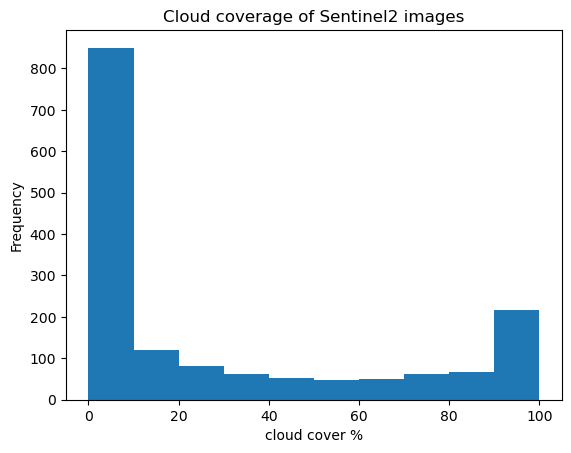

In [81]:
ax: plt.Axes = sentinel_products_metadata.loc[products]['cloudcoverpercentage'].plot(kind='hist', )
ax.set_title('Cloud coverage of Sentinel2 images')
ax.set_xlabel('cloud cover %')

In [82]:
all_metars['timedelta'] = all_metars.apply(lambda row: row['datetime'].to_numpy() - sentinel_products_metadata.loc[row['product_id']]['beginposition'].to_numpy(), axis=1)
all_metars['timedelta [minutes]'] = all_metars['timedelta'].map(lambda x: x.total_seconds() / 60.0)


In [83]:
available_stations_in_products = []
for product in products:
    product_dir = os.path.join(features_dir, product)
    product_bands = os.listdir(product_dir)
    stations = set()
    for band in product_bands:
        band_dir = os.path.join(product_dir, band)
        stations = stations.union(set([Path(file).stem for file in os.listdir(band_dir)]))
    for station in stations:
        available_stations_in_products += [{'product_id': product, 'station': station}]
available_stations_in_products = pd.DataFrame(available_stations_in_products)

In [84]:
available_metars = all_metars[(all_metars['product_id'].isin(products)) \
                              & (all_metars['sky_conditions [M]'].map(lambda x: len(x) > 0))].copy()
keys = list(available_stations_in_products.columns.values)
i1 = available_metars.set_index(keys).index
i2 = available_stations_in_products.set_index(keys).index
available_metars = available_metars[i1.isin(i2)].copy()
print(f'{available_metars.shape[0]} of {all_metars.shape[0]} METARs are available and satisfy requirements'
      f' [{float(available_metars.shape[0]) / float(all_metars.shape[0]) * 100.0:.1f} %]')

8267 of 9759 METARs are available and satisfy requirements [84.7 %]


In [85]:
def get_newest_label(data:pd.DataFrame):
    return data.loc[data['timedelta [minutes]'].abs().idxmin()]

In [86]:
metars = available_metars.groupby(['product_id', 'station'], group_keys=True).apply(lambda x: get_newest_label(x))
print(f'{metars.shape[0]} of {all_metars.shape[0]} METARs remain for the dataset when only taking the nearest timestamp'
      f' [{float(metars.shape[0]) / float(all_metars.shape[0]) * 100.0:.1f} %]')

4232 of 9759 METARs remain for the dataset when only taking the nearest timestamp [43.4 %]


In [87]:
remaining_stations = metars['station'].drop_duplicates().to_numpy()
print(f'{len(remaining_stations)} stations remain')

121 stations remain


Text(0.5, 0, 'time offset in minutes')

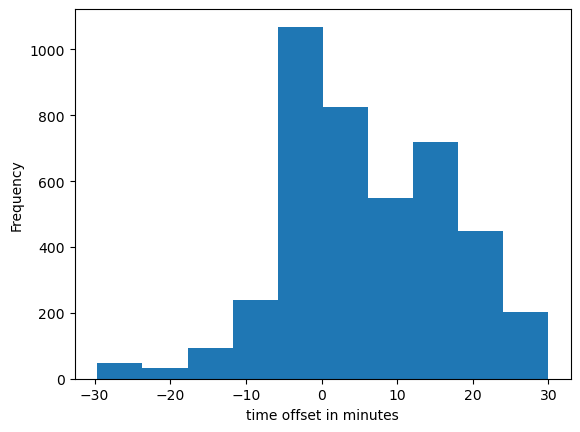

In [143]:
ax: plt.Axes = metars['timedelta [minutes]'].plot(kind='hist')
ax.set_xlabel('time offset in minutes')

In [88]:
station_radius_of_influence = 8000.0 # meters

<class 'shapely.geometry.multipolygon.MultiPolygon'>


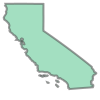

In [89]:
area_of_interest: MultiPolygon = usa_states.loc[target_state].geometry
print(type(area_of_interest))
area_of_interest

In [90]:
def plot_area_of_interest(ax:plt.Axes, color:str):
    gpd.GeoSeries(usa_states.loc[target_state].geometry.buffer(0).boundary).plot(ax=ax, facecolor=color, alpha=1.0, linewidth=0.1, zorder=1)

In [91]:
def reproject_point(point:Point, crs_from, crs_to) -> Point:
    return Point(rasterio.warp.transform_geom(crs_from, crs_to, point)['coordinates'])

def reproject_polygon(polygon:Polygon, crs_from, crs_to) -> Polygon:
    intermediate = rasterio.warp.transform_geom(crs_from, crs_to, polygon)['coordinates']
    return Polygon(*intermediate)

In [92]:
def sphere_of_influence(point:Point, radius:float, crs) -> Polygon:
    crs_intermediate = CRS.from_epsg(32616)
    return reproject_polygon(reproject_point(point, crs, crs_intermediate).buffer(radius),
        crs_intermediate, crs)

In [93]:
remaining_stations_metadata = station_metadata.loc[remaining_stations]

In [94]:
remaining_stations_metadata['geometry'] = remaining_stations_metadata['geometry'].apply(
    lambda x: shapely.box(*sphere_of_influence(x, station_radius_of_influence, CRS.from_epsg(4326)).bounds)
)

In [95]:
intersections: gpd.GeoDataFrame = remaining_stations_metadata[['geometry']].sjoin(remaining_stations_metadata[['geometry']], predicate="intersects")

In [96]:
intersections = intersections[intersections['index_right'] != intersections.index]

In [97]:
intersections = intersections.sample(frac=1, random_state=1)

In [98]:
intersections.head()

,geometry,index_right
id,,
OKB,"POLYGON ((-117.27222 33.15464, -117.27222 33.28537, -117.42774 33.28537, -117.42774 33.15464, -117.27222 33.15464))",NXF
BAB,"POLYGON ((-121.35340 39.07134, -121.35340 39.20085, -121.51969 39.20085, -121.51969 39.07134, -121.35340 39.07134))",MYV
NZY,"POLYGON ((-117.13251 32.62684, -117.13251 32.75753, -117.28707 32.75753, -117.28707 32.62684, -117.13251 32.62684))",SAN
NKX,"POLYGON ((-117.05909 32.79914, -117.05909 32.92995, -117.21409 32.92995, -117.21409 32.79914, -117.05909 32.79914))",MYF
9L2,"POLYGON ((-117.78364 34.92542, -117.78364 35.05621, -117.94256 35.05621, -117.94256 34.92542, -117.78364 34.92542))",EDW


In [99]:
intersections_groups = intersections[['index_right']].groupby('index_right').groups
print(intersections_groups)

{'9L2': ['EDW'], 'AJO': ['CNO'], 'BAB': ['MYV'], 'BUR': ['WHP', 'VNY'], 'CCB': ['ONT', 'POC'], 'CNO': ['ONT', 'POC', 'AJO'], 'CQT': ['LAX', 'SMO', 'HHR'], 'CRQ': ['OKB'], 'DVO': ['O69'], 'EDW': ['9L2'], 'HAF': ['SFO'], 'HHR': ['TOA', 'LAX', 'SMO', 'CQT'], 'HWD': ['OAK'], 'IPL': ['NJK'], 'L18': ['NFG'], 'LAX': ['HHR', 'SMO', 'CQT'], 'LPC': ['VBG'], 'MCC': ['MHR'], 'MCE': ['MER'], 'MER': ['MCE'], 'MHR': ['MCC'], 'MYF': ['NKX', 'NZY', 'SAN'], 'MYV': ['BAB'], 'NFG': ['OKB', 'NXF', 'L18'], 'NJK': ['IPL'], 'NKX': ['SAN', 'MYF'], 'NRS': ['NZY'], 'NUQ': ['PAO', 'SJC'], 'NXF': ['OKB', 'NFG'], 'NZY': ['NRS', 'MYF', 'SAN'], 'O69': ['DVO'], 'OAK': ['HWD', 'SFO'], 'OAR': ['SNS'], 'OKB': ['CRQ', 'NXF', 'NFG'], 'ONT': ['CNO', 'RAL', 'CCB'], 'PAO': ['NUQ', 'SQL'], 'PMD': ['WJF'], 'POC': ['CCB', 'CNO'], 'RAL': ['ONT'], 'SAN': ['NZY', 'NKX', 'MYF'], 'SFO': ['HAF', 'SQL', 'OAK'], 'SJC': ['NUQ'], 'SMO': ['CQT', 'LAX', 'HHR'], 'SNS': ['OAR'], 'SQL': ['SFO', 'PAO'], 'SUU': ['VCB'], 'TOA': ['HHR'], 'VBG': ['

In [100]:
import networkx
import networkx.convert
graph = networkx.convert.from_dict_of_lists(intersections_groups)

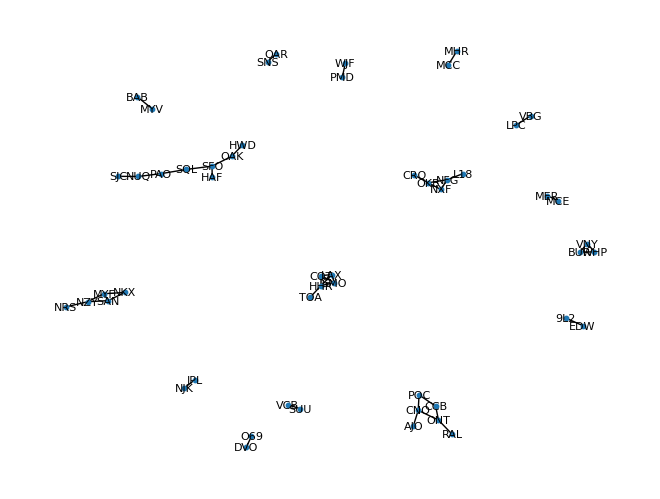

In [101]:
networkx.draw(graph, with_labels=True, font_size=8, node_size=10)

In [102]:
clusters = list(networkx.connected_components(graph))
print(clusters)
num_clusters = len(clusters)

[{'9L2', 'EDW'}, {'CNO', 'ONT', 'CCB', 'AJO', 'POC', 'RAL'}, {'MYV', 'BAB'}, {'WHP', 'BUR', 'VNY'}, {'TOA', 'SMO', 'LAX', 'HHR', 'CQT'}, {'CRQ', 'NXF', 'NFG', 'OKB', 'L18'}, {'DVO', 'O69'}, {'OAK', 'SJC', 'HAF', 'NUQ', 'SQL', 'PAO', 'SFO', 'HWD'}, {'NJK', 'IPL'}, {'LPC', 'VBG'}, {'MHR', 'MCC'}, {'MCE', 'MER'}, {'NZY', 'SAN', 'NRS', 'MYF', 'NKX'}, {'OAR', 'SNS'}, {'WJF', 'PMD'}, {'VCB', 'SUU'}]


In [103]:
def get_mapping_from_clusters(clusters:List[Set[str]]):
    mapping = {}
    current_cluster = 0
    for cluster in clusters:
        for node in cluster:
            mapping[node] = current_cluster
        current_cluster += 1
    return mapping

node_to_cluster_mapping = get_mapping_from_clusters(clusters)
print(node_to_cluster_mapping)

{'9L2': 0, 'EDW': 0, 'CNO': 1, 'ONT': 1, 'CCB': 1, 'AJO': 1, 'POC': 1, 'RAL': 1, 'MYV': 2, 'BAB': 2, 'WHP': 3, 'BUR': 3, 'VNY': 3, 'TOA': 4, 'SMO': 4, 'LAX': 4, 'HHR': 4, 'CQT': 4, 'CRQ': 5, 'NXF': 5, 'NFG': 5, 'OKB': 5, 'L18': 5, 'DVO': 6, 'O69': 6, 'OAK': 7, 'SJC': 7, 'HAF': 7, 'NUQ': 7, 'SQL': 7, 'PAO': 7, 'SFO': 7, 'HWD': 7, 'NJK': 8, 'IPL': 8, 'LPC': 9, 'VBG': 9, 'MHR': 10, 'MCC': 10, 'MCE': 11, 'MER': 11, 'NZY': 12, 'SAN': 12, 'NRS': 12, 'MYF': 12, 'NKX': 12, 'OAR': 13, 'SNS': 13, 'WJF': 14, 'PMD': 14, 'VCB': 15, 'SUU': 15}


In [104]:
clusted_stations = intersections.index.to_list()
print(clusted_stations)
remaining_stations_metadata['cluster'] = remaining_stations_metadata['name'].apply(
    lambda x: node_to_cluster_mapping[x] if x in clusted_stations else -1
)

['OKB', 'BAB', 'NZY', 'NKX', '9L2', 'CNO', 'NFG', 'CRQ', 'OKB', 'SFO', 'PAO', 'HWD', 'PMD', 'HAF', 'ONT', 'NRS', 'BUR', 'VCB', 'NUQ', 'MYV', 'NXF', 'CQT', 'ONT', 'PAO', 'NUQ', 'SFO', 'L18', 'CCB', 'VBG', 'WJF', 'SJC', 'OKB', 'MYF', 'LAX', 'MCC', 'NXF', 'SAN', 'TOA', 'ONT', 'CNO', 'SFO', 'RAL', 'NZY', 'IPL', 'NKX', 'LAX', 'POC', 'SUU', 'LPC', 'OAK', 'SAN', 'NFG', 'NFG', 'MYF', 'SNS', 'SMO', 'BUR', 'HHR', 'O69', 'POC', 'MYF', 'HHR', 'NZY', 'WHP', 'CCB', 'LAX', 'MCE', 'SMO', 'SQL', 'OAK', 'VNY', 'SMO', 'HHR', 'SAN', 'HHR', 'VNY', 'EDW', 'AJO', 'DVO', 'CQT', 'OAR', 'CNO', 'NJK', 'MHR', 'WHP', 'MER', 'CQT', 'SQL']


<Axes: title={'center': 'California'}>

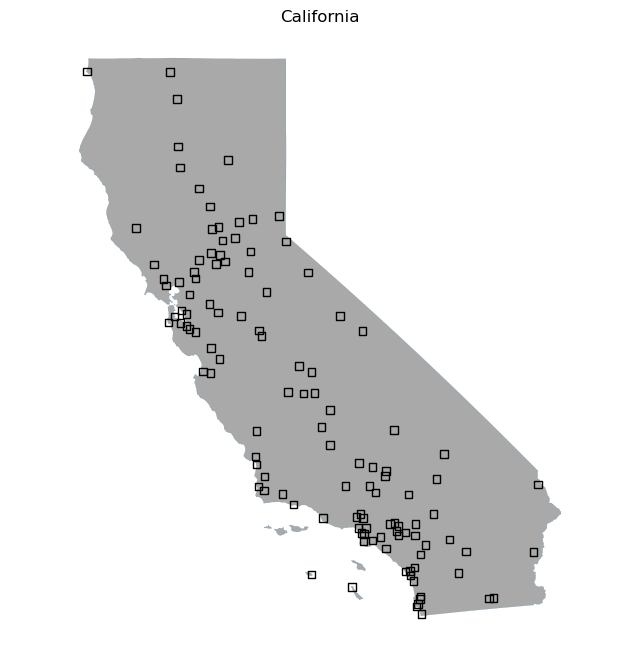

In [105]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal', 'datalim')
ax.set_title(target_state)
ax.axis(False)
plot_area_of_interest(ax, 'darkgray')

remaining_stations_metadata.plot(
    ax=ax, facecolor='none', edgecolor='black', legend=True
)

c:\Users\erikw\anaconda3\lib\site-packages\geopandas\plotting.py:642: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


<Axes: title={'center': 'California'}>

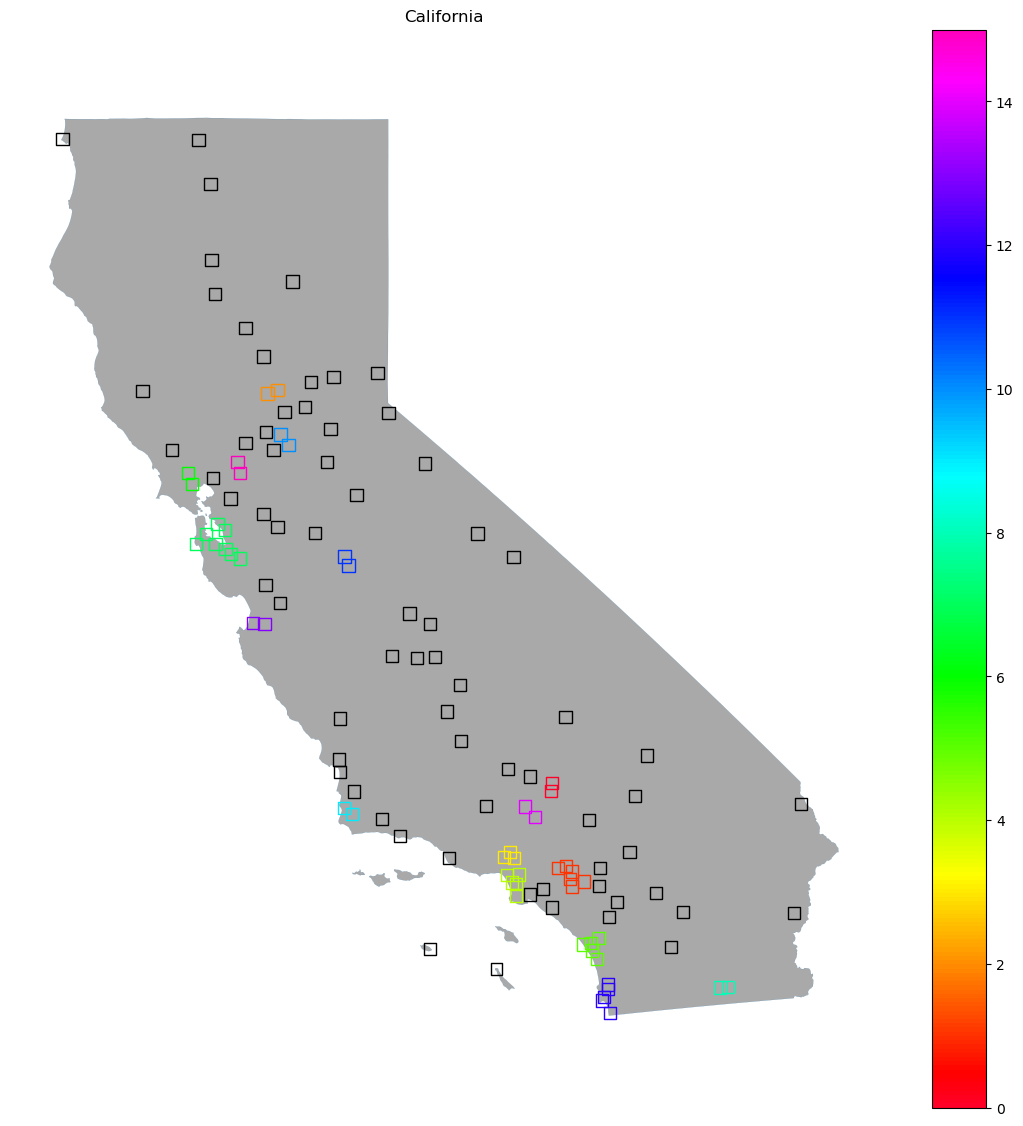

In [106]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.set_aspect('equal', 'datalim')
ax.set_title(target_state)
ax.axis(False)
plot_area_of_interest(ax, 'darkgray')

remaining_stations_metadata[remaining_stations_metadata['cluster'] == -1].plot(
    ax=ax, facecolor='none', edgecolor='black', legend=True
)
remaining_stations_metadata[remaining_stations_metadata['cluster'] != -1].plot(
    column='cluster', ax=ax, facecolor='none', colormap='gist_rainbow', legend=True
)

In [107]:
cloud_covers = pd.DataFrame(metars['sky_conditions [M]'])
cloud_covers['cloud cover'] = cloud_covers['sky_conditions [M]'].apply(lambda sky_conditions: [cond.cover for cond in sky_conditions])
cloud_covers

sky_conditions [M]  \
product_id                           station                                                                                                                                            
00065e39-660f-4b17-a4ff-d528b87cef65 BIH                                                                                    [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     MMH                                                                                    [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
002276a1-d3f5-494d-93c8-92e199d63501 APC      [DataSkyConditions(cover='SCT', height=457.1999853696, cloud=None), DataSkyConditions(cover='BKN', height=1828.7999414784, cloud=None)]   
                                     CCR                                                                         [DataSkyConditions(cover='FEW', height=2133.5999317248, cloud=None)]   
                                     DVO                                                                          [DataSkyConditions(cover='FEW', height=883.9199717146, cloud=None)]   
...                                                                                                                                                                               ...   
ffcb7dba-8287-4d61-b3f8-268beba9901d O69                                                                                    [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     STS                                                                          [DataSkyConditions(cover='SCT', height=6095.999804928, cloud=None)]   
                                     SUU                                                                                    [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     VCB                                                                                    [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
ffef155f-3c61-4e07-a2c4-39a61331917d DLO                                                                          [DataSkyConditions(cover='OVC', height=152.3999951232, cloud=None)]   

                                             cloud cover  
product_id                           station              
00065e39-660f-4b17-a4ff-d528b87cef65 BIH           [CLR]  
                                     MMH           [CLR]  
002276a1-d3f5-494d-93c8-92e199d63501 APC      [SCT, BKN]  
                                     CCR           [FEW]  
                                     DVO           [FEW]  
...                                                  ...  
ffcb7dba-8287-4d61-b3f8-268beba9901d O69           [CLR]  
                                     STS           [SCT]  
                                     SUU           [CLR]  
                                     VCB           [CLR]  
ffef155f-3c61-4e07-a2c4-39a61331917d DLO           [OVC]  

[4232 rows x 2 columns]

In [108]:
cloud_covers_flat = [item for sublist in cloud_covers['cloud cover'] for item in sublist]
print(cloud_covers_flat)

['CLR', 'CLR', 'SCT', 'BKN', 'FEW', 'FEW', 'SCT', 'SCT', 'BKN', 'CLR', 'FEW', 'SCT', 'SCT', 'BKN', 'BKN', 'BKN', 'CLR', 'SCT', 'BKN', 'OVC', 'FEW', 'FEW', 'BKN', 'FEW', 'BKN', 'CLR', 'SCT', 'SCT', 'CLR', 'CLR', 'FEW', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'OVC', 'BKN', 'OVC', 'CLR', 'SCT', 'OVC', 'SCT', 'OVC', 'CLR', 'CLR', 'CLR', 'FEW', 'FEW', 'FEW', 'FEW', 'FEW', 'SCT', 'FEW', 'FEW', 'SCT', 'SCT', 'CLR', 'FEW', 'SCT', 'FEW', 'FEW', 'SCT', 'BKN', 'BKN', 'OVC', 'OVC', 'SCT', 'OVC', 'FEW', 'BKN', 'SCT', 'CLR', 'FEW', 'FEW', 'CLR', 'CLR', 'CLR', 'SCT', 'CLR', 'CLR', 'CLR', 'FEW', 'SCT', 'FEW', 'CLR', 'FEW', 'SCT', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'FEW', 'FEW', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'OVC', 'BKN', 'BKN', 'BKN', 'FEW', 'BKN', 'BKN', 'BKN', 'SCT', 'BKN', 'OVC', 'BKN', 'OVC', 'FEW', 'OVC', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'FEW', 'CLR', 'CLR', 'CLR'

<Axes: >

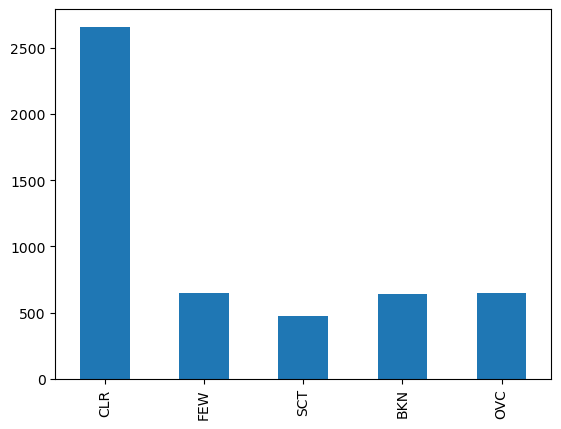

In [109]:
pd.Series(dict(Counter(cloud_covers_flat))).loc[cloud_covers_order].plot(kind='bar')

In [110]:
cloud_cover_strength = {
    'CLR': 0,
    'FEW': 1,
    'SCT': 3,
    'BKN': 5,
    'OVC': 8
}

def get_max_cloud_cover(cloud_covers:List[DataSkyConditions]):
    cloud_covers_ranked = [(cloud_cover_strength[cc.cover],cc.cover) if cc.cover in cloud_cover_strength else (-1,cc.cover) for cc in cloud_covers]
    if any(cloud_covers_ranked):
        return max(cloud_covers_ranked)[1]
    else:
        return None

In [111]:
metars['max cloud cover'] = metars['sky_conditions [M]'].apply(get_max_cloud_cover)

In [112]:
cloud_covers['cloud cover max'] = cloud_covers['sky_conditions [M]'].map(get_max_cloud_cover)
cloud_covers['cloud cover max']

product_id                            station
00065e39-660f-4b17-a4ff-d528b87cef65  BIH        CLR
                                      MMH        CLR
002276a1-d3f5-494d-93c8-92e199d63501  APC        BKN
                                      CCR        FEW
                                      DVO        FEW
                                                ... 
ffcb7dba-8287-4d61-b3f8-268beba9901d  O69        CLR
                                      STS        SCT
                                      SUU        CLR
                                      VCB        CLR
ffef155f-3c61-4e07-a2c4-39a61331917d  DLO        OVC
Name: cloud cover max, Length: 4232, dtype: object

In [113]:
pd.Series(dict(Counter(cloud_covers['cloud cover max'])))

CLR    2659
BKN     352
FEW     310
SCT     248
OVC     651
VV       12
dtype: int64

<Axes: title={'center': 'Maximum cloud coverage by weather stations'}>

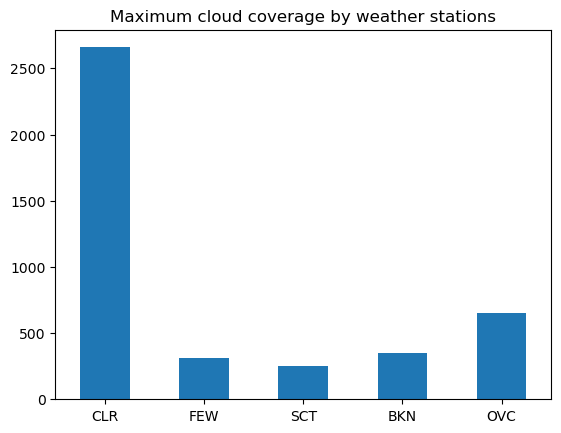

In [114]:
pd.Series(dict(Counter(cloud_covers['cloud cover max'])))\
    .loc[cloud_covers_order].plot(kind='bar', title='Maximum cloud coverage by weather stations', rot=0)

In [115]:
cloud_covers

sky_conditions [M]  \
product_id                           station                                                                                                                                            
00065e39-660f-4b17-a4ff-d528b87cef65 BIH                                                                                    [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     MMH                                                                                    [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
002276a1-d3f5-494d-93c8-92e199d63501 APC      [DataSkyConditions(cover='SCT', height=457.1999853696, cloud=None), DataSkyConditions(cover='BKN', height=1828.7999414784, cloud=None)]   
                                     CCR                                                                         [DataSkyConditions(cover='FEW', height=2133.5999317248, cloud=None)]   
                                     DVO                                                                          [DataSkyConditions(cover='FEW', height=883.9199717146, cloud=None)]   
...                                                                                                                                                                               ...   
ffcb7dba-8287-4d61-b3f8-268beba9901d O69                                                                                    [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     STS                                                                          [DataSkyConditions(cover='SCT', height=6095.999804928, cloud=None)]   
                                     SUU                                                                                    [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     VCB                                                                                    [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
ffef155f-3c61-4e07-a2c4-39a61331917d DLO                                                                          [DataSkyConditions(cover='OVC', height=152.3999951232, cloud=None)]   

                                             cloud cover cloud cover max  
product_id                           station                              
00065e39-660f-4b17-a4ff-d528b87cef65 BIH           [CLR]             CLR  
                                     MMH           [CLR]             CLR  
002276a1-d3f5-494d-93c8-92e199d63501 APC      [SCT, BKN]             BKN  
                                     CCR           [FEW]             FEW  
                                     DVO           [FEW]             FEW  
...                                                  ...             ...  
ffcb7dba-8287-4d61-b3f8-268beba9901d O69           [CLR]             CLR  
                                     STS           [SCT]             SCT  
                                     SUU           [CLR]             CLR  
                                     VCB           [CLR]             CLR  
ffef155f-3c61-4e07-a2c4-39a61331917d DLO           [OVC]             OVC  

[4232 rows x 3 columns]

In [116]:
cloud_covers_max_per_station = {}
for station, data in cloud_covers.groupby('station'):
    cloud_covers_max_per_station[station] = pd.Series(dict(Counter(data['cloud cover max'])))
cloud_covers_max_per_station = pd.DataFrame(cloud_covers_max_per_station)
cloud_covers_max_per_station

,9L2,AJO,APC,AUN,BAB,BAN,BFL,BIH,BLH,BLU,...,TSP,TVL,UKI,VBG,VCB,VCV,VIS,VNY,WHP,WJF
BKN,NaN,1.0,6.0,NaN,1.0,1.0,2.0,1.0,NaN,NaN,...,2.0,4.0,2.0,5.0,2.0,NaN,NaN,NaN,1.0,1.0
CLR,26.0,26.0,15.0,26.0,21.0,19.0,50.0,27.0,24.0,24.0,...,30.0,76.0,20.0,9.0,21.0,31.0,16.0,21.0,21.0,33.0
FEW,2.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,...,NaN,4.0,1.0,3.0,NaN,NaN,NaN,1.0,NaN,1.0
OVC,1.0,4.0,7.0,9.0,9.0,3.0,9.0,2.0,NaN,3.0,...,3.0,19.0,6.0,5.0,6.0,1.0,9.0,5.0,3.0,2.0
SCT,NaN,1.0,1.0,1.0,3.0,1.0,NaN,NaN,2.0,1.0,...,NaN,NaN,1.0,6.0,1.0,NaN,NaN,2.0,1.0,NaN
VV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,3.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


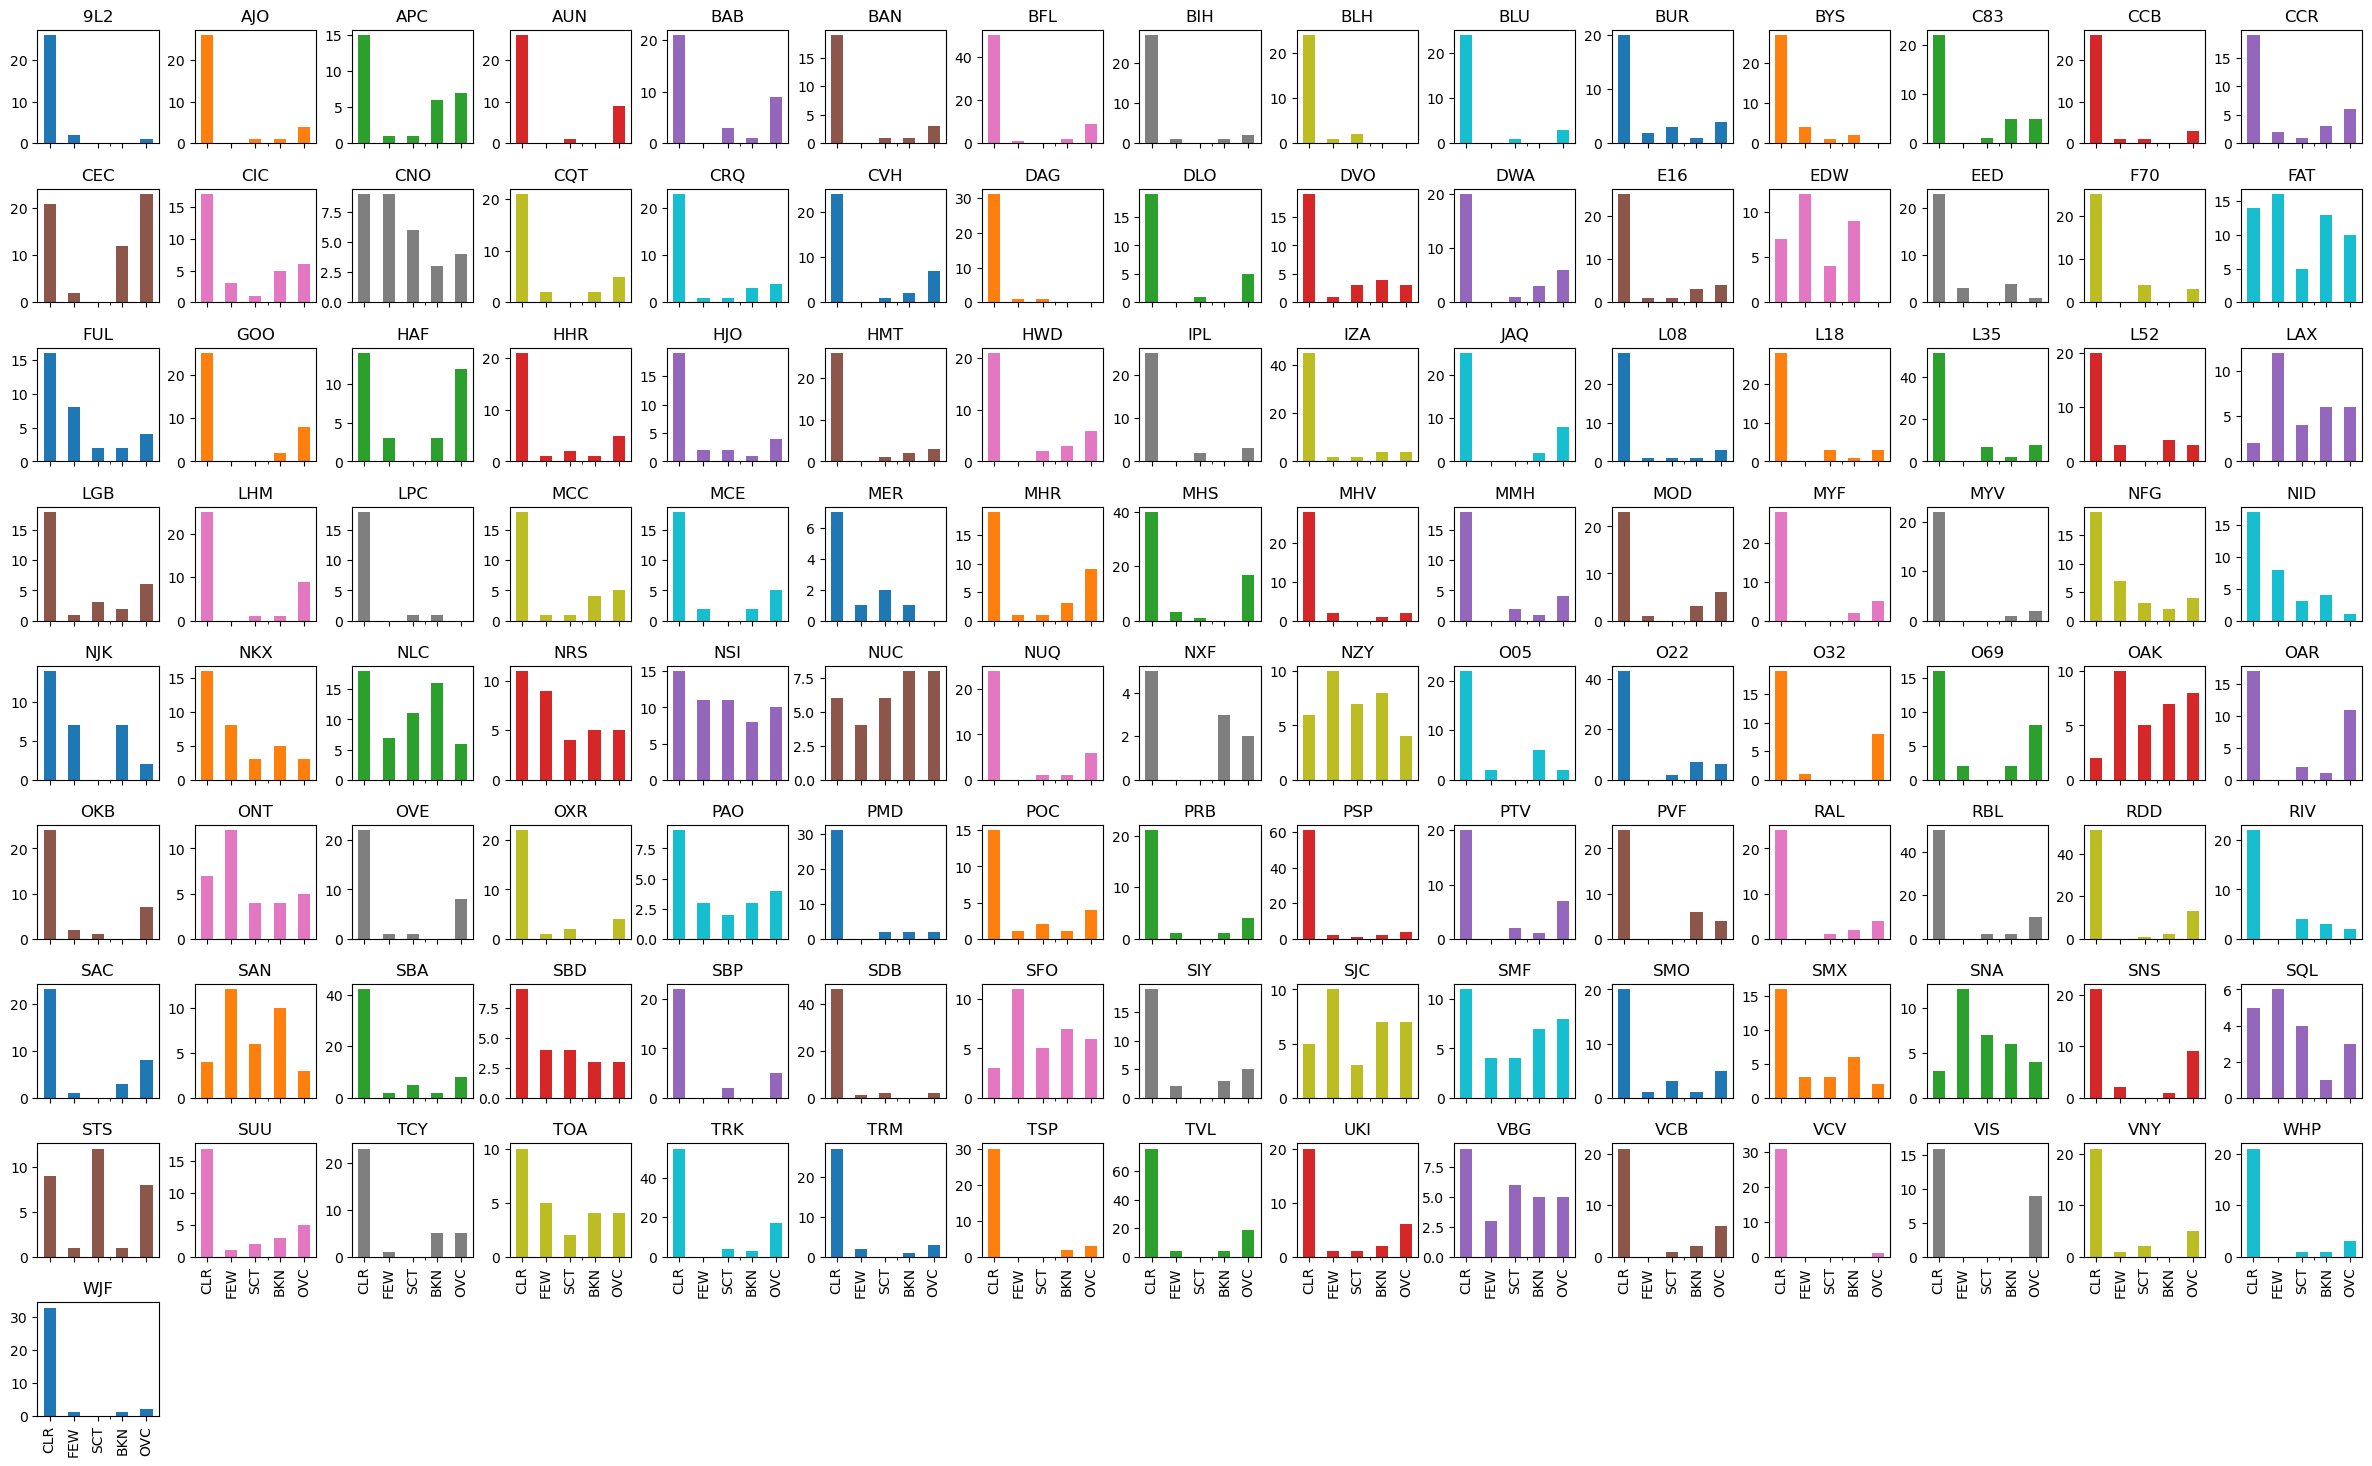

In [117]:
from numpy import ceil

plot_share_x = True
plot_layout_scale = 2.0
plot_layout_columns = 15
plot_layout_rows = int(ceil(cloud_covers_max_per_station.shape[1] / plot_layout_columns))
cloud_covers_max_per_station.loc[cloud_covers_order].plot(kind='bar', sharex=plot_share_x, subplots=True, legend=False,
    layout=(plot_layout_rows, plot_layout_columns),
    figsize=(plot_layout_columns * plot_layout_scale, plot_layout_rows * plot_layout_scale))
if not plot_share_x:
    plt.subplots_adjust(wspace=0.3, hspace=1.0)
else:
    plt.subplots_adjust(wspace=0.3, hspace=0.4)

In [118]:
metar_station_counts = metars.reset_index(drop=True).groupby(['station'])['product_id'].count().sort_values()

<Axes: xlabel='station'>

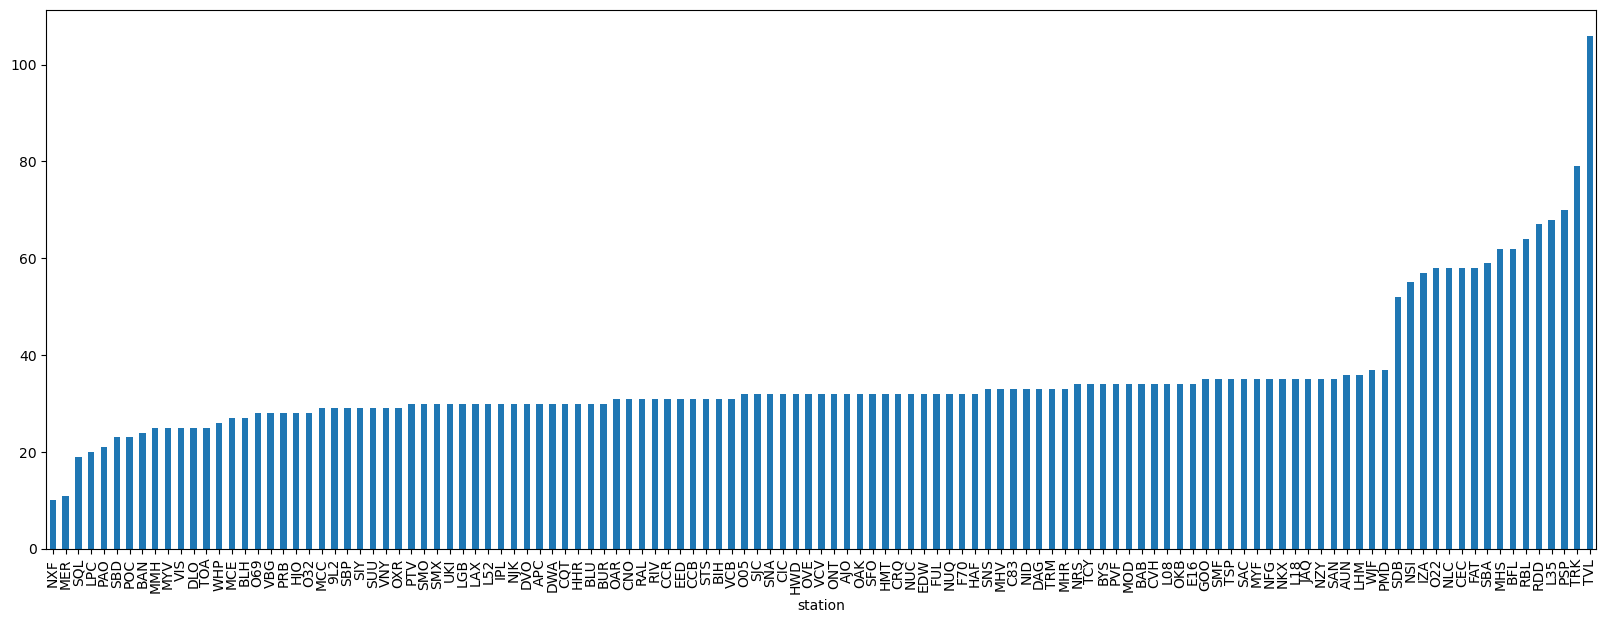

In [119]:
metar_station_counts.plot(kind='bar', figsize=(20,7))

<Axes: ylabel='Frequency'>

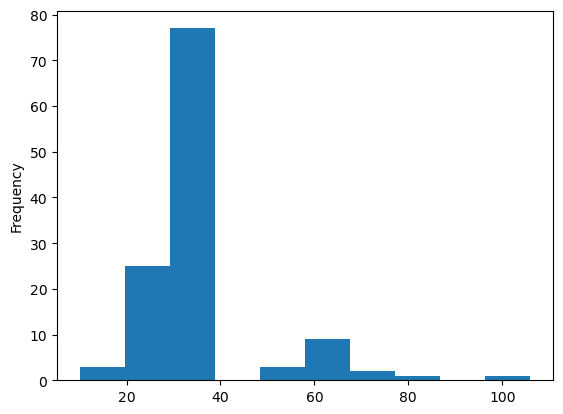

In [120]:
metar_station_counts.plot(kind='hist')

In [121]:
station_quantity = metars.reset_index(drop=True).groupby('station')['product_id'].count()
station_quantity

station
9L2    29
AJO    32
APC    30
AUN    36
BAB    34
       ..
VCV    32
VIS    25
VNY    29
WHP    26
WJF    37
Name: product_id, Length: 121, dtype: int64

In [122]:
@dataclass
class DatasetUnit:
    stations: Set[str]
    quantity: int

    def __lt__(self, other):
         return (self.quantity, self.stations) < (other.quantity, self.stations)

In [123]:
stations_not_in_cluster = set(remaining_stations_metadata['name']).difference(set.union(*clusters))
print(stations_not_in_cluster)

{'RBL', 'OXR', 'CCR', 'HMT', 'RIV', 'MMH', 'SDB', 'O32', 'E16', 'FUL', 'SBD', 'UKI', 'SMX', 'AUN', 'SNA', 'EED', 'NID', 'MOD', 'O05', 'CIC', 'GOO', 'VCV', 'JAQ', 'SMF', 'TCY', 'F70', 'SBP', 'DWA', 'O22', 'L52', 'L08', 'BLH', 'NSI', 'RDD', 'PRB', 'PTV', 'SIY', 'MHV', 'LHM', 'TRM', 'L35', 'CEC', 'HJO', 'DLO', 'NLC', 'IZA', 'STS', 'OVE', 'BAN', 'TSP', 'BYS', 'SBA', 'PVF', 'LGB', 'SAC', 'TVL', 'DAG', 'MHS', 'APC', 'TRK', 'NUC', 'BFL', 'PSP', 'CVH', 'BIH', 'BLU', 'FAT', 'VIS', 'C83'}


In [124]:
dataset_units: List[DatasetUnit] = []
for cluster in clusters:
    dataset_units += [DatasetUnit(cluster, sum([station_quantity.loc[station] for station in cluster]))]
dataset_units += [DatasetUnit(set([station]), station_quantity.loc[station]) for station in stations_not_in_cluster]
print(dataset_units)

[DatasetUnit(stations={'9L2', 'EDW'}, quantity=61), DatasetUnit(stations={'CNO', 'ONT', 'CCB', 'AJO', 'POC', 'RAL'}, quantity=180), DatasetUnit(stations={'MYV', 'BAB'}, quantity=59), DatasetUnit(stations={'WHP', 'BUR', 'VNY'}, quantity=85), DatasetUnit(stations={'TOA', 'SMO', 'LAX', 'HHR', 'CQT'}, quantity=145), DatasetUnit(stations={'CRQ', 'NXF', 'NFG', 'OKB', 'L18'}, quantity=146), DatasetUnit(stations={'DVO', 'O69'}, quantity=58), DatasetUnit(stations={'OAK', 'SJC', 'HAF', 'NUQ', 'SQL', 'PAO', 'SFO', 'HWD'}, quantity=232), DatasetUnit(stations={'NJK', 'IPL'}, quantity=60), DatasetUnit(stations={'LPC', 'VBG'}, quantity=48), DatasetUnit(stations={'MHR', 'MCC'}, quantity=62), DatasetUnit(stations={'MCE', 'MER'}, quantity=38), DatasetUnit(stations={'NZY', 'SAN', 'NRS', 'MYF', 'NKX'}, quantity=174), DatasetUnit(stations={'OAR', 'SNS'}, quantity=64), DatasetUnit(stations={'WJF', 'PMD'}, quantity=74), DatasetUnit(stations={'VCB', 'SUU'}, quantity=60), DatasetUnit(stations={'RBL'}, quantity

Text(0.5, 0, 'Average number of METARS per satellite image')

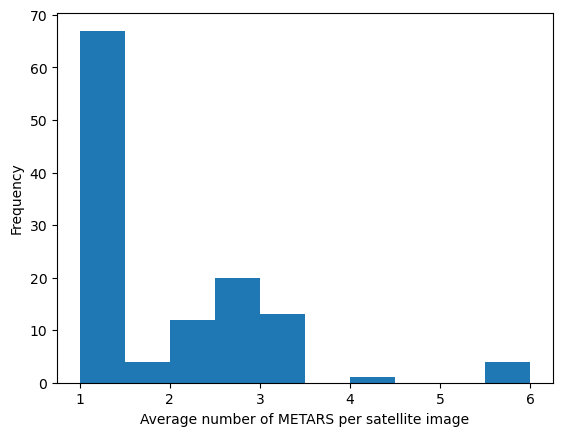

In [125]:
ax: plt.Axes = available_metars.groupby(['station', 'product_id'])['datetime'].count().groupby('station').mean().plot(kind='hist',
    title='')
ax.set_xlabel('Average number of METARS per satellite image')

Text(0.5, 0, 'quantity of METARs')

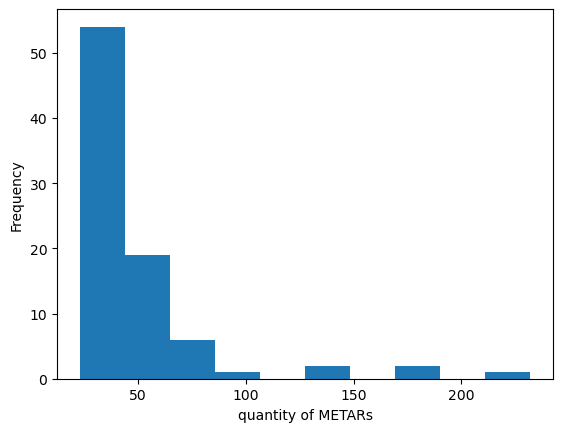

In [126]:
ax: plt.Axes = pd.DataFrame(dataset_units).plot(kind='hist', legend=False)
ax.set_xlabel('quantity of METARs')

In [127]:
total_quantity = sum([entry.quantity for entry in dataset_units])
print(f'In total, {total_quantity} units of data are to be distributed for the dataset')

In total, 4232 units of data are to be distributed for the dataset


In [128]:
@dataclass
class DatasetSplit:
    training: float
    validation: float
    test: float

    def __init__(self, training: float, validation: float, test: float) -> None:
        if not math.isclose(training + validation + test, 1.0):
            raise ValueError('DatasetSplit must sum to 1.0 (100 %)')
        self.training = training
        self.validation = validation
        self.test = test
    
    def getAbsoluteNumbers(self, total_quantity:int) -> Tuple[int, int, int]:
        test_abs        = int(math.ceil(total_quantity * self.test))
        validation_abs  = int(math.ceil(total_quantity * self.validation))
        training_abs    = total_quantity - test_abs - validation_abs
        return (training_abs, validation_abs, test_abs)

In [129]:
dataset_split = DatasetSplit(0.80, 0.10, 0.10)
num_training, num_validation, num_test = dataset_split.getAbsoluteNumbers(total_quantity)
print(f'DatasetSplit target:'
      f'\nTraining:\t{num_training}\t[{dataset_split.training * 100.0:.1f} %]'
      f'\nValidation:\t{num_validation}\t[{dataset_split.validation * 100.0:.1f} %]'
      f'\nTest:\t\t{num_test}\t[{dataset_split.test * 100.0:.1f} %]')

DatasetSplit target:
Training:	3384	[80.0 %]
Validation:	424	[10.0 %]
Test:		424	[10.0 %]


In [130]:
dataset_units.sort(reverse=True)
dataset_units

[DatasetUnit(stations={'OAK', 'SJC', 'HAF', 'NUQ', 'SQL', 'PAO', 'SFO', 'HWD'}, quantity=232),
 DatasetUnit(stations={'CNO', 'ONT', 'CCB', 'AJO', 'POC', 'RAL'}, quantity=180),
 DatasetUnit(stations={'NZY', 'SAN', 'NRS', 'MYF', 'NKX'}, quantity=174),
 DatasetUnit(stations={'CRQ', 'NXF', 'NFG', 'OKB', 'L18'}, quantity=146),
 DatasetUnit(stations={'TOA', 'SMO', 'LAX', 'HHR', 'CQT'}, quantity=145),
 DatasetUnit(stations={'TVL'}, quantity=106),
 DatasetUnit(stations={'WHP', 'BUR', 'VNY'}, quantity=85),
 DatasetUnit(stations={'TRK'}, quantity=79),
 DatasetUnit(stations={'WJF', 'PMD'}, quantity=74),
 DatasetUnit(stations={'PSP'}, quantity=70),
 DatasetUnit(stations={'L35'}, quantity=68),
 DatasetUnit(stations={'RDD'}, quantity=67),
 DatasetUnit(stations={'OAR', 'SNS'}, quantity=64),
 DatasetUnit(stations={'RBL'}, quantity=64),
 DatasetUnit(stations={'MHR', 'MCC'}, quantity=62),
 DatasetUnit(stations={'MHS'}, quantity=62),
 DatasetUnit(stations={'BFL'}, quantity=62),
 DatasetUnit(stations={'9L

In [131]:
@dataclass
class Dataset:
    data: List[DatasetUnit]
    current_size: int
    target_size: int

    def add(self, unit:DatasetUnit):
        self.data += [unit]
        self.current_size += unit.quantity

    def get_missing_quantity(self) -> int:
        return self.target_size - self.current_size
    
    def get_stations(self) -> Set[str]:
        return set.union(*[x.stations for x in self.data])

In [132]:
def greedy_partition(split:DatasetSplit, total_quantity:int, data:List[DatasetUnit]):
    num_training, num_validation, num_test = dataset_split.getAbsoluteNumbers(total_quantity)
    training    = Dataset([], 0, num_training)
    validation  = Dataset([], 0, num_validation)
    test        = Dataset([], 0, num_test)
    for unit in data:
        # Get the dataset that is missing the most data
        next_dataset = max([
            (training.get_missing_quantity(),      training),
            (validation.get_missing_quantity(),  validation),
            (test.get_missing_quantity(),              test)
        ], key=lambda x: x[0])[1]
        next_dataset.add(unit)
    return (training, validation, test)

In [133]:
training, validation, test = greedy_partition(dataset_split, total_quantity, dataset_units)
print(f'DatasetSplit:'
      f'\nTraining:\t{training.current_size}\t[{float(training.current_size) / float(total_quantity) * 100.0:.1f} %]'
      f'\nValidation:\t{validation.current_size}\t[{float(validation.current_size) / float(total_quantity) * 100.0:.1f} %]'
      f'\nTest:\t\t{test.current_size}\t[{float(test.current_size) / float(total_quantity) * 100.0:.1f} %]')

DatasetSplit:
Training:	3384	[80.0 %]
Validation:	424	[10.0 %]
Test:		424	[10.0 %]


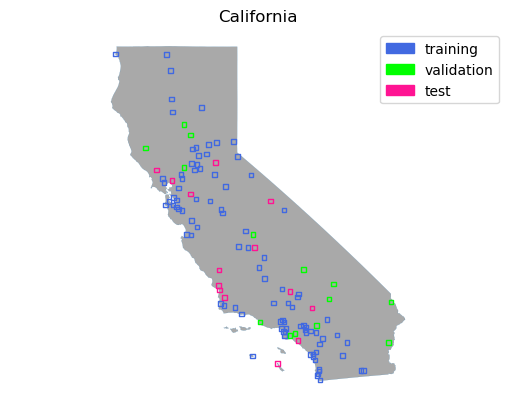

In [138]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title(target_state)
ax.axis(False)
plot_area_of_interest(ax, 'darkgray')

color_training = 'royalblue'
color_validation = 'lime'
color_test = 'deeppink'

patch_training = mpatches.Patch(color=color_training, label='training')
patch_validation = mpatches.Patch(color=color_validation, label='validation')
patch_test = mpatches.Patch(color=color_test, label='test')

remaining_stations_metadata.loc[list(training.get_stations())].plot(
    ax=ax, facecolor='none', edgecolor=color_training, legend=True
)
remaining_stations_metadata.loc[list(validation.get_stations())].plot(
    ax=ax, facecolor='none', edgecolor=color_validation, legend=True
)
remaining_stations_metadata.loc[list(test.get_stations())].plot(
    ax=ax, facecolor='none', edgecolor=color_test, legend=True
)

ax.legend(handles=[patch_training, patch_validation, patch_test])

In [255]:
os.makedirs(dataset_dir, exist_ok=True)
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')
os.makedirs(training_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [256]:
print(training.get_stations())

{'NSI', 'CEC', 'SMO', 'HWD', 'IZA', 'TVL', 'MYF', 'NFG', 'SUU', 'MHR', 'OAK', 'NUQ', 'CCB', 'SMF', 'FAT', 'LAX', 'GOO', 'L08', 'CVH', 'DVO', 'SBP', 'BAN', 'CRQ', 'MHS', 'SDB', 'SMX', 'SNS', 'E16', 'L35', 'BFL', 'PSP', 'SQL', 'MYV', 'WHP', 'BLU', 'LPC', 'TRK', 'O32', 'O22', 'PVF', 'JAQ', 'RBL', 'POC', 'PAO', 'PMD', 'WJF', 'HMT', 'VCB', 'CCR', 'SBA', 'NJK', 'SFO', 'NZY', 'EDW', 'ONT', 'LHM', 'MOD', 'CQT', 'TOA', 'SAN', 'NXF', 'NLC', 'CNO', 'MCC', 'AJO', 'BUR', 'SAC', 'EED', '9L2', 'O69', 'RDD', 'NKX', 'OVE', 'TSP', 'L18', 'VIS', 'VNY', 'AUN', 'OAR', 'MCE', 'C83', 'MER', 'RAL', 'HAF', 'SJC', 'VCV', 'OKB', 'VBG', 'BAB', 'HHR', 'IPL', 'RIV', 'NRS'}


In [257]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
band_resolutions_meters = [60, 10, 10, 10, 20, 20, 20, 10, 20, 60, 60, 20, 20]

In [260]:
def get_features_path(station:str, product_id:str, band:str):
    return os.path.join(features_dir, product_id, band, f'{station}.jp2')

def get_dataset_local_dir(station:str, product_id:str):
    return os.path.join(station, product_id)

def get_dataset_path(target_dir:str, station:str, product_id:str, band:str):
    return os.path.join(target_dir, get_dataset_local_dir(station, product_id), f'{band}.jp2')

def map_files_to_dataset_paths(dataset:Dataset, target_dir:str) -> List[Tuple[str, str]]:
    data_subset = metars[(metars['station'].isin(dataset.get_stations()))\
                                   & (metars['max cloud cover'].isin(cloud_covers_order))]
    result = data_subset.apply(
        lambda x: [(get_features_path(x.station, x.product_id, band),
                    get_dataset_path(target_dir, x.station, x.product_id, band)) for band in bands], axis=1)
    return [x for sublist in result for x in sublist]

In [261]:
dataset_file_mappings = [mapping for sublist in [
    map_files_to_dataset_paths(training, training_dir),
    map_files_to_dataset_paths(validation, validation_dir),
    map_files_to_dataset_paths(test, test_dir)
] for mapping in sublist]

In [262]:
for path_from, path_to in dataset_file_mappings:
    os.makedirs(os.path.dirname(path_to), exist_ok=True)
    if not os.path.exists(path_to):
        shutil.copyfile(path_from, path_to)

In [267]:
def create_dataset_labels(dataset:Dataset):
    labels = metars.reset_index(drop=True)
    labels = labels[labels['station'].isin(dataset.get_stations())\
                              & (labels['max cloud cover'].isin(cloud_covers_order))].copy()
    labels['timedelta [minutes]'] = labels['timedelta'].map(lambda x: x.total_seconds() / 60.0)
    labels = labels[['max cloud cover', 'temperature [C]', 'timedelta [minutes]', 'station', 'product_id']]
    return labels.groupby(['product_id', 'station'], group_keys=True).apply(lambda x: get_newest_label(x))

In [268]:
training_labels = create_dataset_labels(training)
validation_labels = create_dataset_labels(validation)
test_labels = create_dataset_labels(test)

<Axes: title={'center': 'Test'}, ylabel='Frequency'>

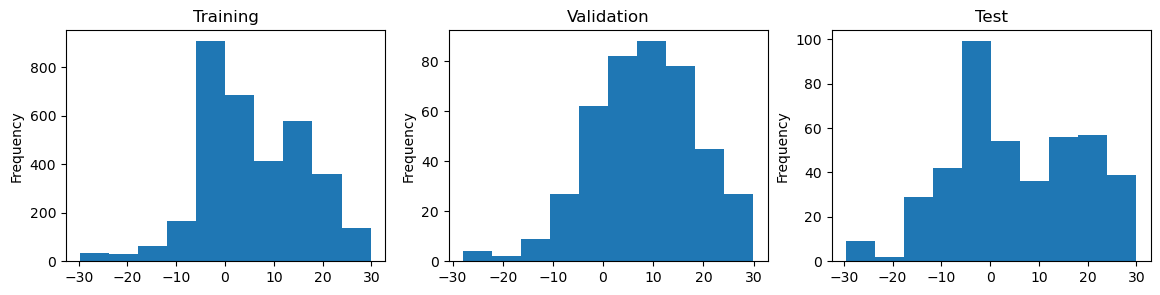

In [269]:
fig, axs = plt.subplots(ncols=3, figsize=(14,3))
training_labels['timedelta [minutes]'].plot(kind='hist', ax=axs[0], title='Training')
validation_labels['timedelta [minutes]'].plot(kind='hist', ax=axs[1], title='Validation')
test_labels['timedelta [minutes]'].plot(kind='hist', ax=axs[2], title='Test')

In [271]:
def print_time_dist(data:pd.DataFrame, name:str):
    series = data['timedelta [minutes]']
    print(f'{name}\tmean offset: {series.mean():.1f} minutes,\tvariance: {series.var():.1f}')

print_time_dist(training_labels, 'Training')
print_time_dist(validation_labels, 'Validation')
print_time_dist(test_labels, 'Test\t')

Training	mean offset: 5.8 minutes,	variance: 117.7
Validation	mean offset: 8.1 minutes,	variance: 111.2
Test		mean offset: 5.3 minutes,	variance: 179.3


In [272]:
training_labels.shape[0]

3373

In [273]:
training_label_counts = pd.Series(dict(Counter(training_labels['max cloud cover'])))
validation_label_counts = pd.Series(dict(Counter(validation_labels['max cloud cover'])))
test_label_counts = pd.Series(dict(Counter(test_labels['max cloud cover'])))

<Axes: title={'center': 'Test'}>

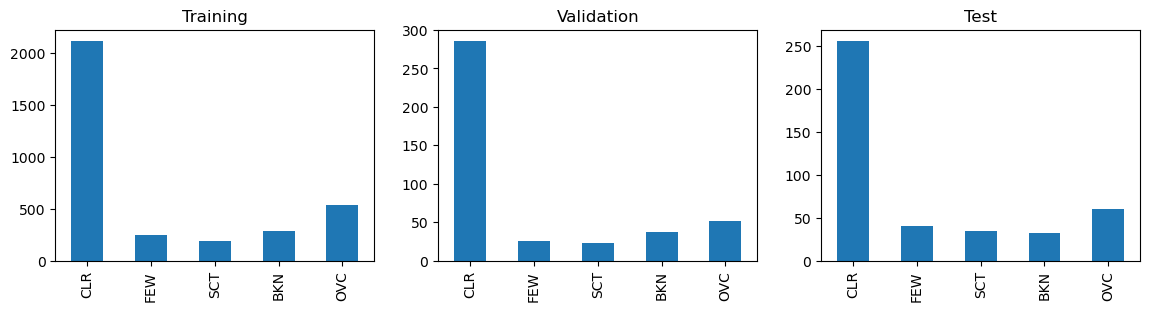

In [274]:
fig, axs = plt.subplots(ncols=3, figsize=(14,3))
training_label_counts.loc[cloud_covers_order].plot(kind='bar', ax=axs[0], title='Training')
validation_label_counts.loc[cloud_covers_order].plot(kind='bar', ax=axs[1], title='Validation')
test_label_counts.loc[cloud_covers_order].plot(kind='bar', ax=axs[2], title='Test')

In [275]:
training_labels.to_csv(os.path.join(dataset_dir, 'training_labels.csv'), index=False)
validation_labels.to_csv(os.path.join(dataset_dir, 'validation_labels.csv'), index=False)
test_labels.to_csv(os.path.join(dataset_dir, 'test_labels.csv'), index=False)

In [294]:
def get_label_weights(label_counts:pd.DataFrame):
    label_weights = pd.DataFrame(1 - label_counts / label_counts.sum(), columns=['weight'])
    label_weights.index.set_names('label', inplace=True)
    return label_weights.loc[cloud_covers_order]

In [295]:
training_weights = get_label_weights(training_label_counts)
training_weights

,weight
label,
CLR,0.372369
FEW,0.927661
SCT,0.943670
BKN,0.916098
OVC,0.840202


In [296]:
training_weights.to_csv(os.path.join(dataset_dir, 'training_weights.csv'))

In [297]:
bands_metadata = pd.DataFrame([bands, band_resolutions_meters]).T
bands_metadata.columns = ['band', 'resolution [M]']
bands_metadata

,band,resolution [M]
0,B1,60
1,B2,10
2,B3,10
3,B4,10
4,B5,20
5,B6,20
6,B7,20
7,B8,10
8,B8A,20
9,B9,60


In [298]:
bands_metadata.to_csv(os.path.join(dataset_dir, 'bands_metadata.csv'), index=False)